In [5]:
# Import Packaes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning packages
from sklearn.preprocessing import StandardScaler  # Maybe use MinMaxScaler?
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


# Prevents Pandas Copy Warning
pd.set_option("mode.copy_on_write", True)
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_rows', None)

## Exploratory Data Analysis

In [ ]:
folder_path = './data/ieee-fraud-detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
#test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
#test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')

# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
#test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

Train dataset has 590540 rows and 434 columns.


In [12]:
print(f'Train transaction dataset has {train_transaction.shape[0]} rows and {train_transaction.shape[1]} columns.')
print(f'Train identity dataset has {train_identity.shape[0]} rows and {train_identity.shape[1]} columns.')
print(f'Merged Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')

train.head()

Train transaction dataset has 590540 rows and 394 columns.
Train identity dataset has 144233 rows and 41 columns.
Merged Train dataset has 590540 rows and 434 columns.


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


After loading in the dataset we observe the following:

- There are 590,540 observation and 434 variables.

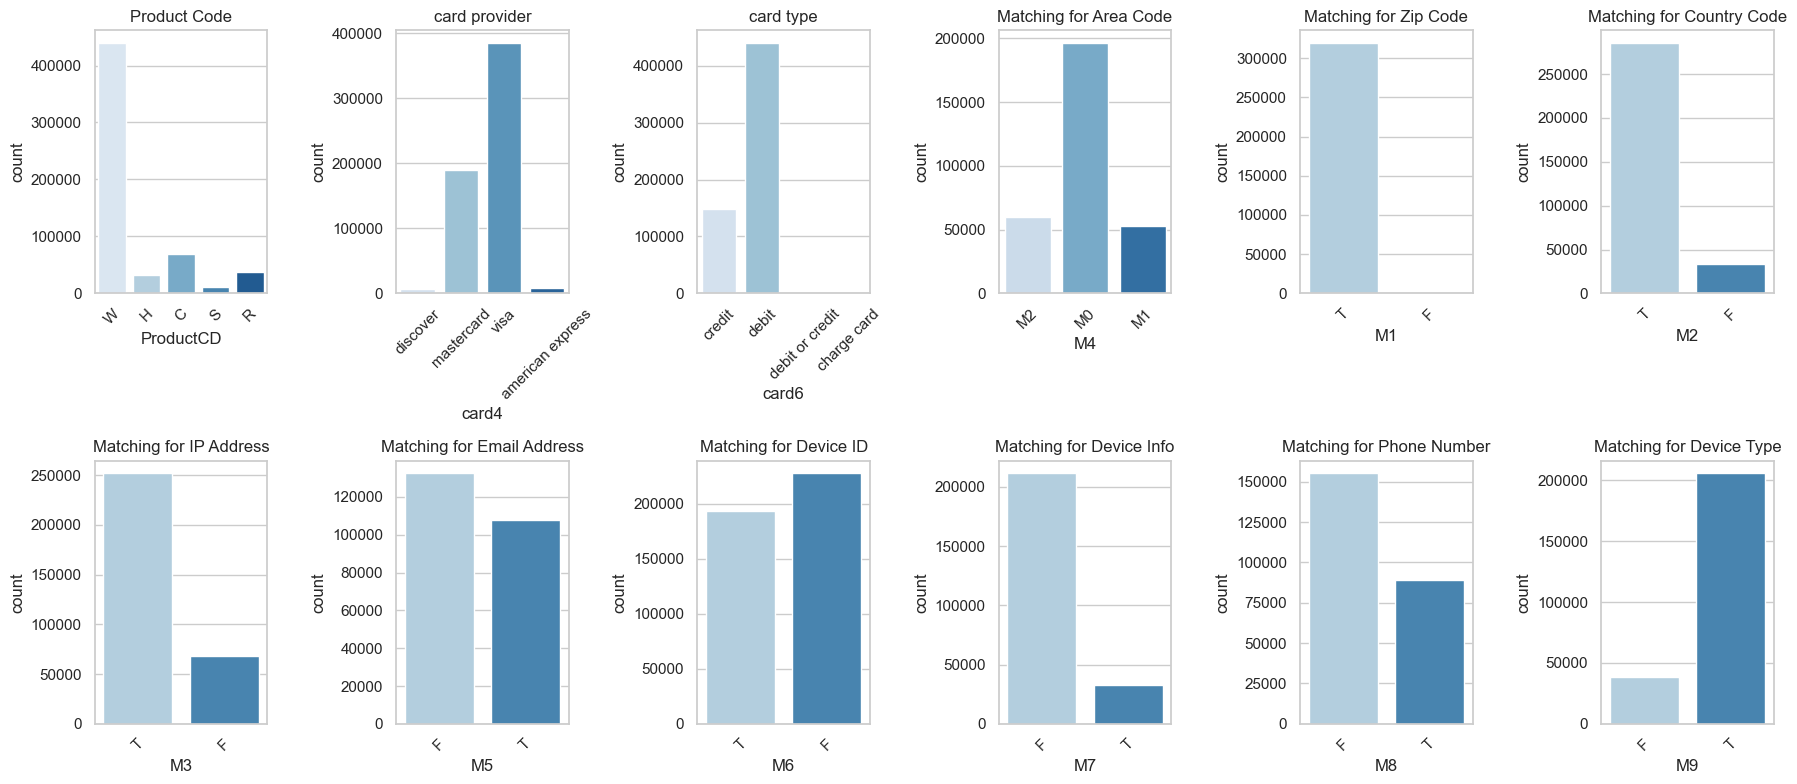

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical features to plot
features = ['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

# List of names for each feature (match order with features list)
names = ['Product Code', 'card provider', 'card type', 'Matching for Area Code', 'Matching for Zip Code', 
         'Matching for Country Code', 'Matching for IP Address', 'Matching for Email Address', 
         'Matching for Device ID','Matching for Device Info', 'Matching for Phone Number', 'Matching for Device Type']

# Assuming the train data is already loaded as 'train'
# Set the figure size with a smaller height
plt.figure(figsize=(18, 8))  # Reduced height

# Create subplots to plot each feature's distribution with 6 columns
for i, (feature, name) in enumerate(zip(features, names), 1):
    plt.subplot(2, 6, i)  # Arrange subplots in 2 rows and 6 columns
    sns.countplot(data=train, x=feature, hue=feature, palette='Blues', legend=False)  # Set hue and palette
    plt.title(f'{name}')  # Use the descriptive names from the list
    plt.xticks(rotation=45)  # Rotate x labels for readability
    plt.tight_layout()

# Show the plot
plt.show()

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\2423255624.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['dayofweek'] = (train['TransactionDT']//(60*60*24)-1)%7
C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\2423255624.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axes2 = sns.barplot(x=tmp['dayofweek'],y=tmp['Number of transactions'],palette='summer')


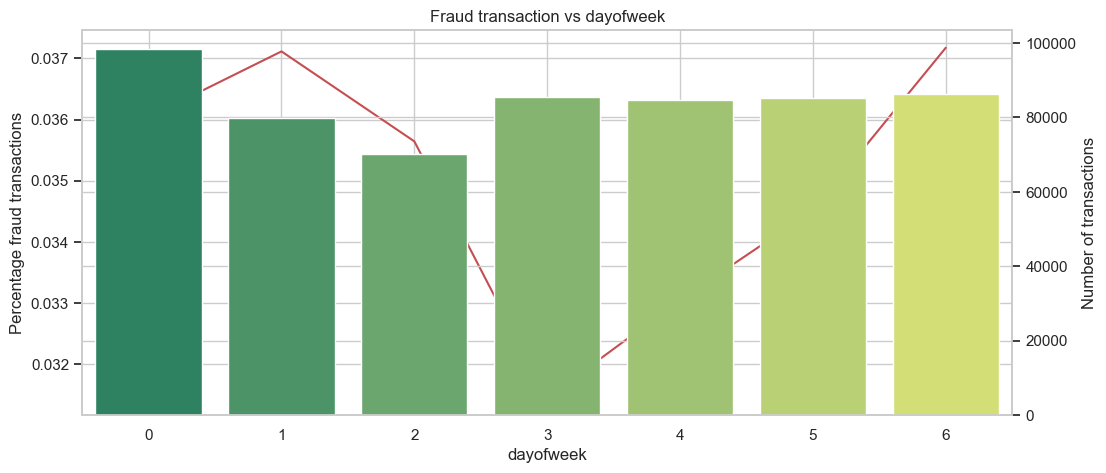

In [33]:
train['dayofweek'] = (train['TransactionDT']//(60*60*24)-1)%7
tmp = train[['isFraud','dayofweek']].groupby(by=['dayofweek']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_count = train[['TransactionID','dayofweek']].groupby(by=['dayofweek']).count().reset_index() \
            .rename(columns={'TransactionID':'Number of transactions'})
tmp = tmp.merge(tmp_count,on=['dayofweek'])




fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['dayofweek'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['dayofweek'],y=tmp['Number of transactions'],palette='summer')
axes.set_title('Fraud transaction vs dayofweek')
plt.show()


C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\2591509939.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['hour'] = (train['TransactionDT']//(60*60))%24
C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\2591509939.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axes2 = sns.barplot(x=tmp['hour'],y=tmp['Number of transactions'],palette='summer')


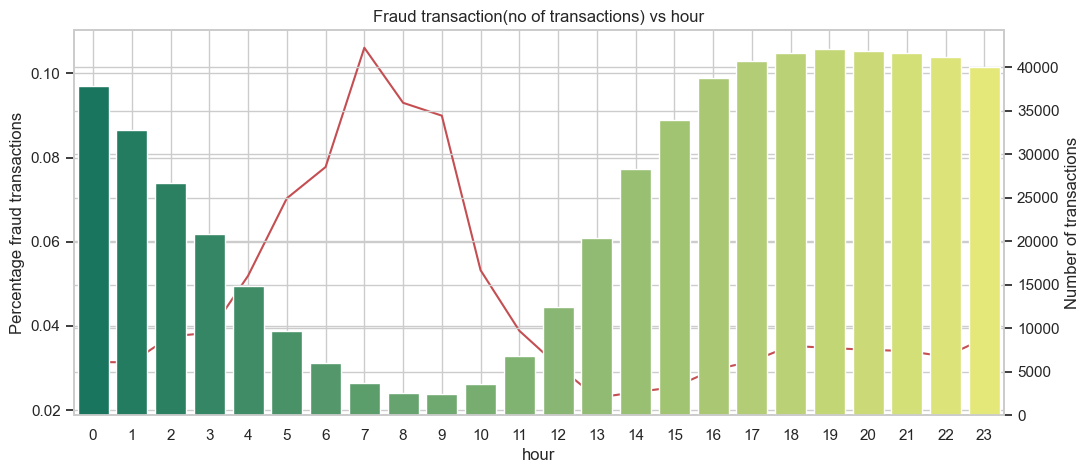

In [35]:
train['hour'] = (train['TransactionDT']//(60*60))%24
tmp = train[['isFraud','hour']].groupby(by=['hour']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_count = train[['TransactionID','hour']].groupby(by=['hour']).count().reset_index() \
            .rename(columns={'TransactionID':'Number of transactions'})
tmp = tmp.merge(tmp_count,on=['hour'])




fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['hour'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['hour'],y=tmp['Number of transactions'],palette='summer')
axes.set_title('Fraud transaction(no of transactions) vs hour')
plt.show()

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\3543168159.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dff_notfraud['TransactionAmt'],ax=axes[0],label='not fraud')
C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\3543168159.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(d

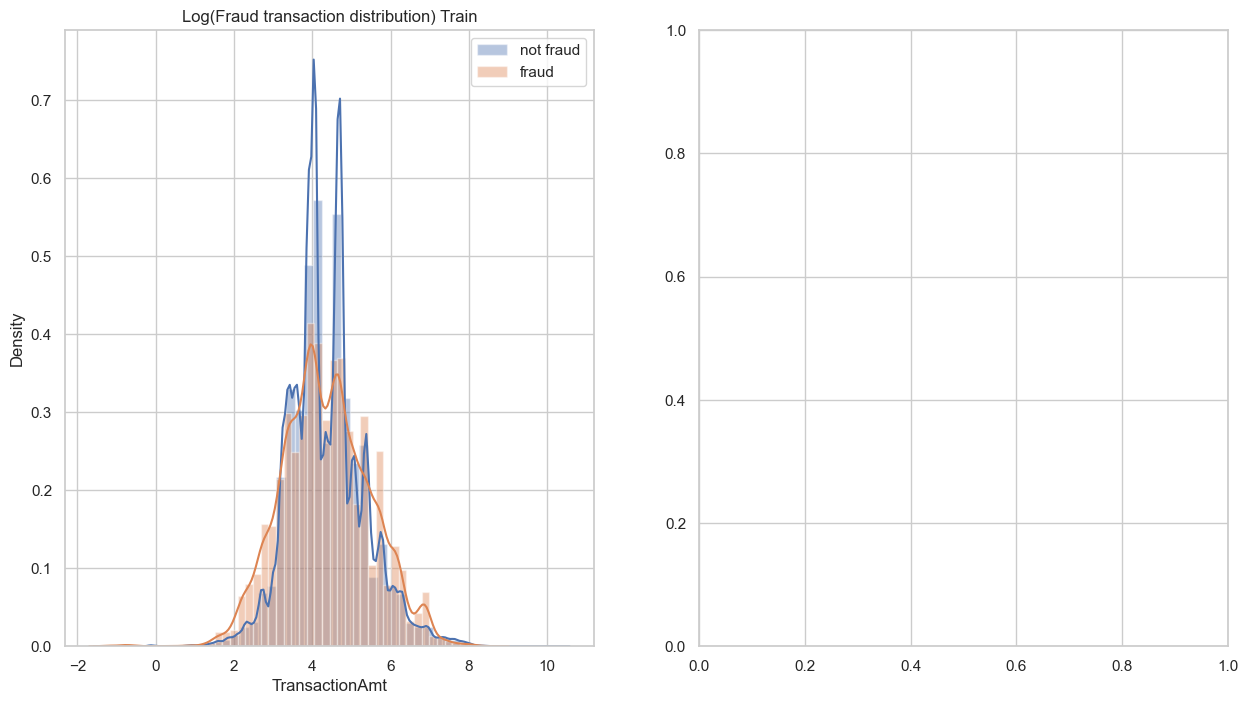

In [37]:
#test_amt = np.log(df_test[['TransactionAmt']])

dff_fraud = train[train['isFraud'] == 1]
dff_notfraud = train[train['isFraud'] == 0]

dff_fraud['TransactionAmt'] = np.log(dff_fraud['TransactionAmt'])
dff_notfraud['TransactionAmt'] = np.log(dff_notfraud['TransactionAmt'])


fig,axes = plt.subplots(1,2,figsize=(15,8))
sns.distplot(dff_notfraud['TransactionAmt'],ax=axes[0],label='not fraud')
sns.distplot(dff_fraud['TransactionAmt'],ax=axes[0],label='fraud')
axes[0].title.set_text('Log(Fraud transaction distribution) Train')
axes[0].legend()

#sns.distplot(test_amt,ax=axes[1])
#axes[1].title.set_text('Log(Fraud transaction distribution) Test')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
sns.boxplot(dff_notfraud['TransactionAmt'],ax=axes[0])
axes[0].title.set_text('Log(Non Fraud transaction distribution)')
axes[0].set(xlim=(0, 12))
sns.boxplot(dff_fraud['TransactionAmt'],ax=axes[1],color=colors[2])
axes[1].title.set_text('Log(Fraud transaction distribution)')
axes[1].set(xlim=(0, 12))
plt.show()

print('Mean transaction amt for fraud is {:.4f} ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].mean(),np.exp(dff_fraud['TransactionAmt'].mean())))
print('Mean transaction amt for non-fraud is {:.4f} ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].mean(),np.exp(dff_notfraud['TransactionAmt'].mean())))

print('Median transaction amt for fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_fraud['TransactionAmt'].median(),np.exp(dff_fraud['TransactionAmt'].median())))
print('Median transaction amt for non-fraud is {:.4f}  ie, {:.4f} dollars'.format(dff_notfraud['TransactionAmt'].median(),np.exp(dff_notfraud['TransactionAmt'].median())))

In [32]:
def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [17]:
from ydata_profiling import ProfileReport

# Generate the profile report
profile = ProfileReport(
    train,
    title="IEEE Fraud Detection Dataset Report",
    minimal=True,  # Faster report with essential information
    explorative=True,  # Adds interactive visualizations for large dataframes
    vars={
        "cat": {
            "check_impact": False,  # Focus on categorical proportions without additional impact metrics
            "count": True,          # Display counts and nulls for categorical variables
        },
        "num": {
            "quantile": True,  # Display quantile-based statistics for continuous variables
        }
    }
)

# Save the report as an HTML file
profile.to_file("ieee_fraud_detection_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\3049252538.py:19: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object.


  X_filtered[column].fillna(X_filtered[column].median(), inplace=True)
C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\3049252538.py:19: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the inte

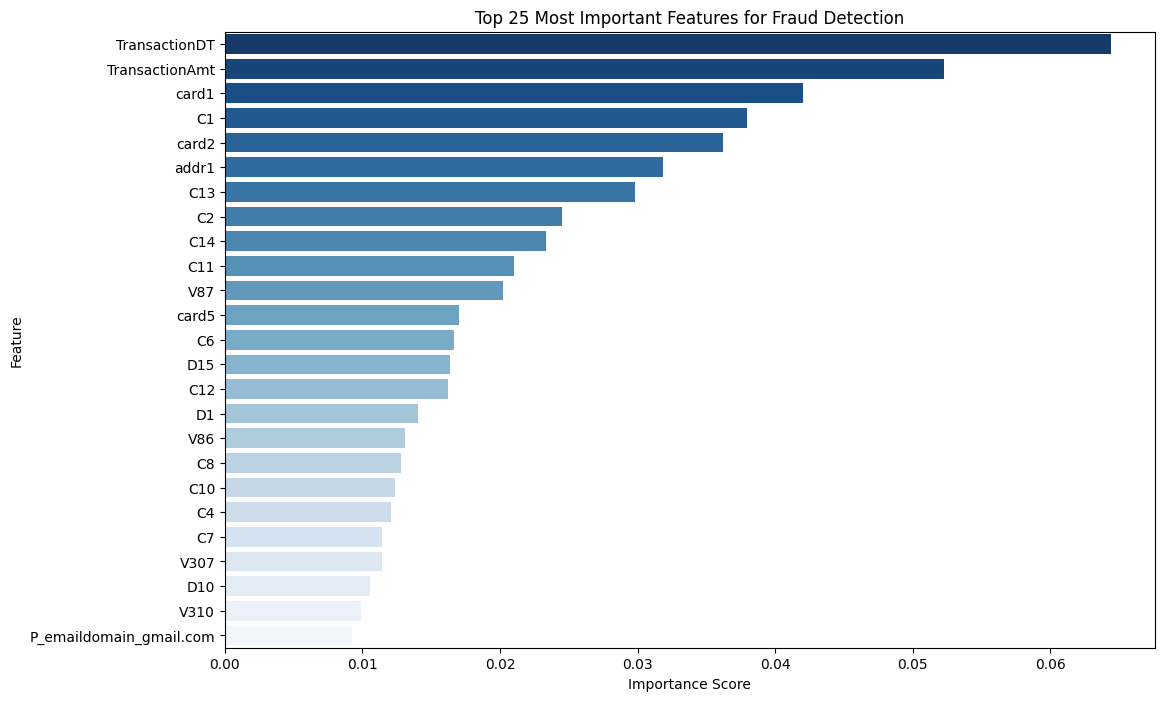

In [19]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Separate target and drop 'TransactionID' column
y = train['isFraud']
X = train.drop(columns=['isFraud', 'TransactionID'])

# Step 1: Filter out columns with >25% missing values
missing_percentages = X.isnull().mean() * 100
X_filtered = X.loc[:, missing_percentages <= 25]

# Step 2: Impute missing values before encoding
for column in X_filtered.columns:
    if X_filtered[column].dtype == 'float64' or X_filtered[column].dtype == 'int64':  # Continuous variables
        X_filtered[column].fillna(X_filtered[column].median(), inplace=True)
    else:  # Categorical variables
        X_filtered[column].fillna(X_filtered[column].mode()[0], inplace=True)

# Step 3: Encode categorical features
X_encoded = pd.get_dummies(X_filtered, drop_first=True)

# Step 4: Split the data for training (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 6: Calculate feature importances
importances = rf.feature_importances_
feature_names = X_encoded.columns

# Create a DataFrame with feature importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance and select the top 25 features
top_features = importance_df.sort_values(by='importance', ascending=False).head(25)

# Plot the top 25 features
plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, y='feature', x='importance', palette='Blues_r')
plt.title("Top 25 Most Important Features for Fraud Detection")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


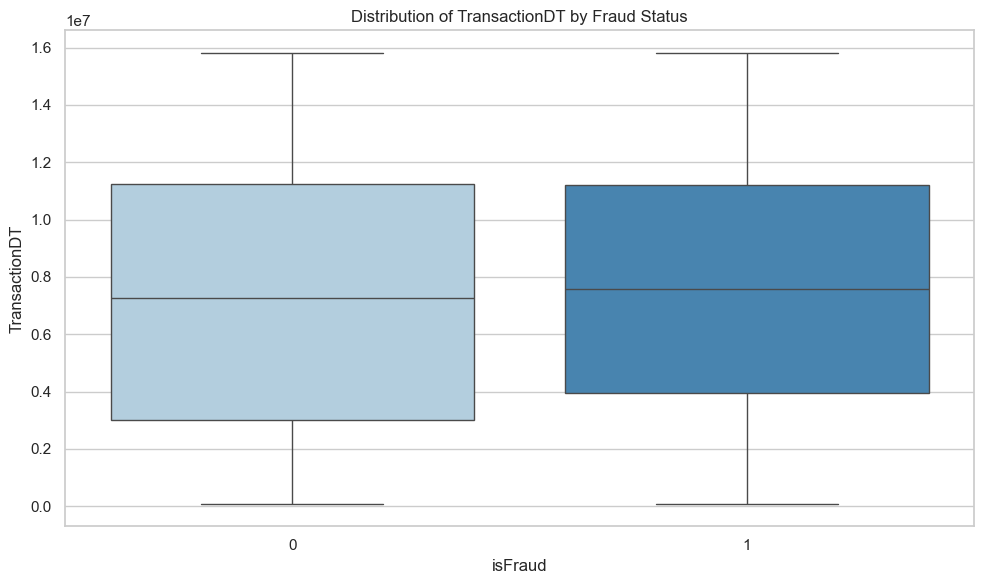

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


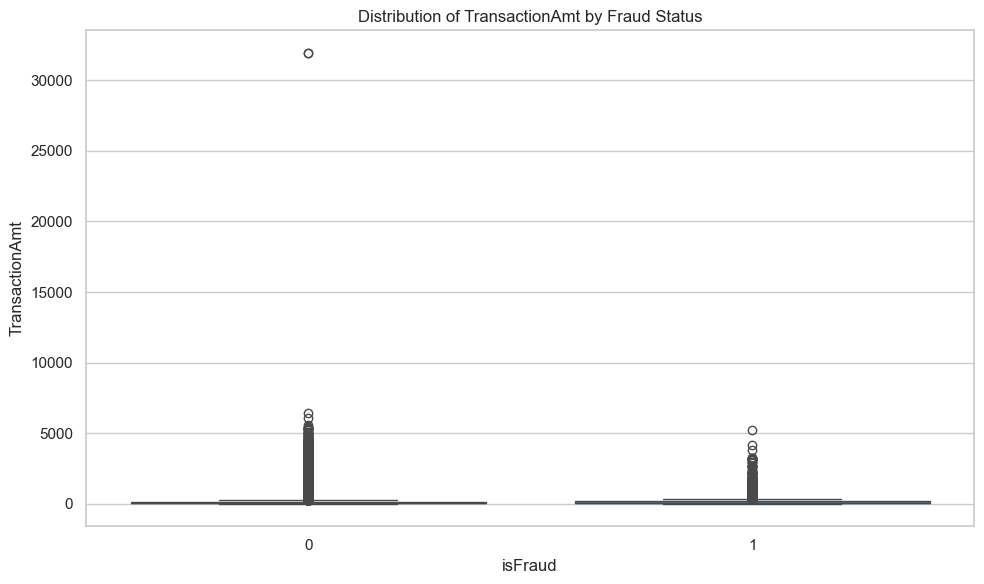

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


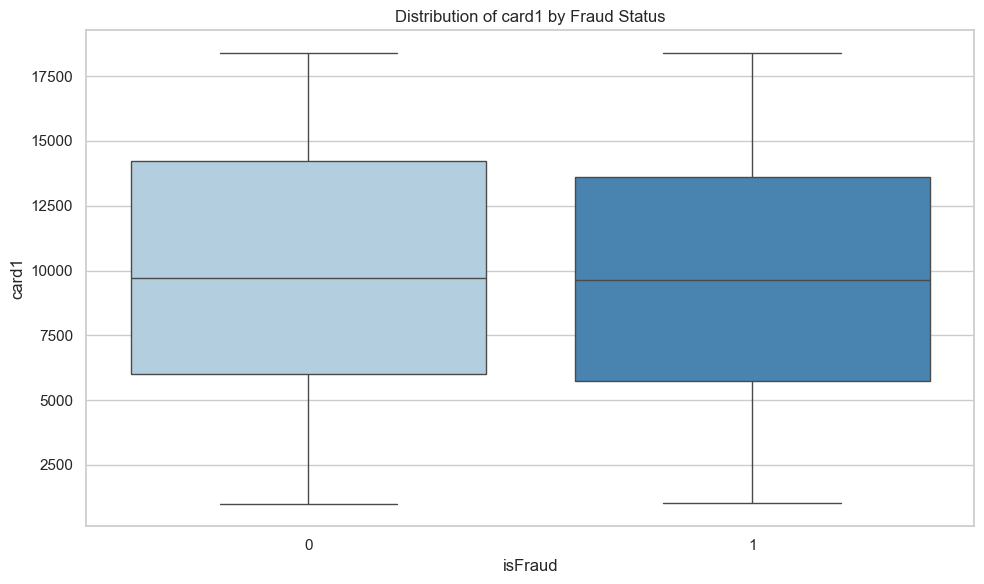

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


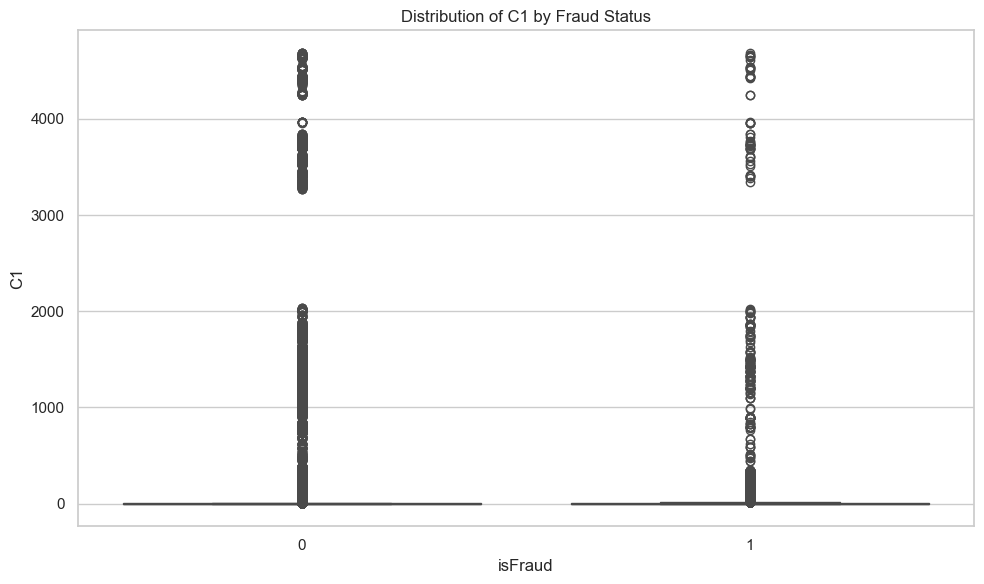

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


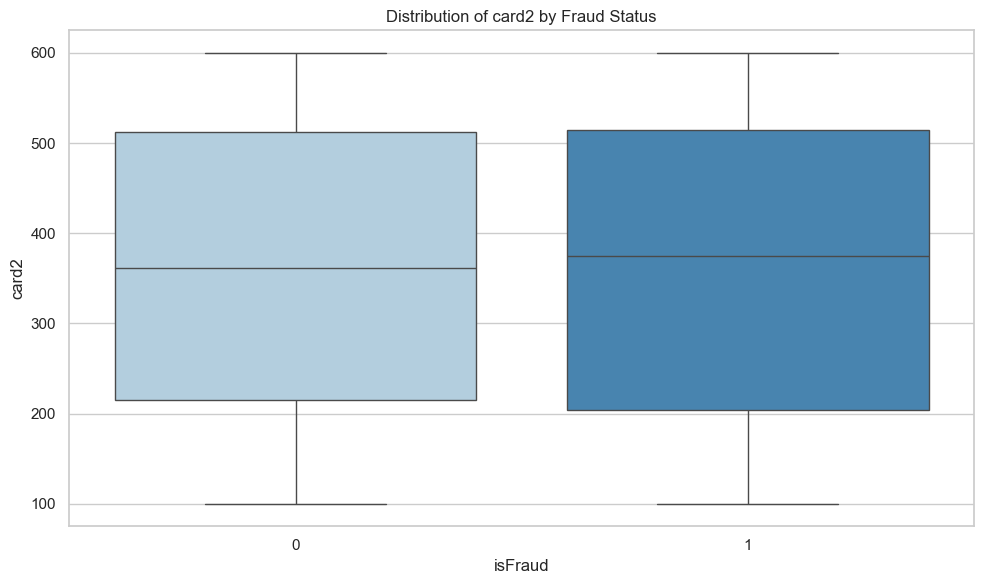

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


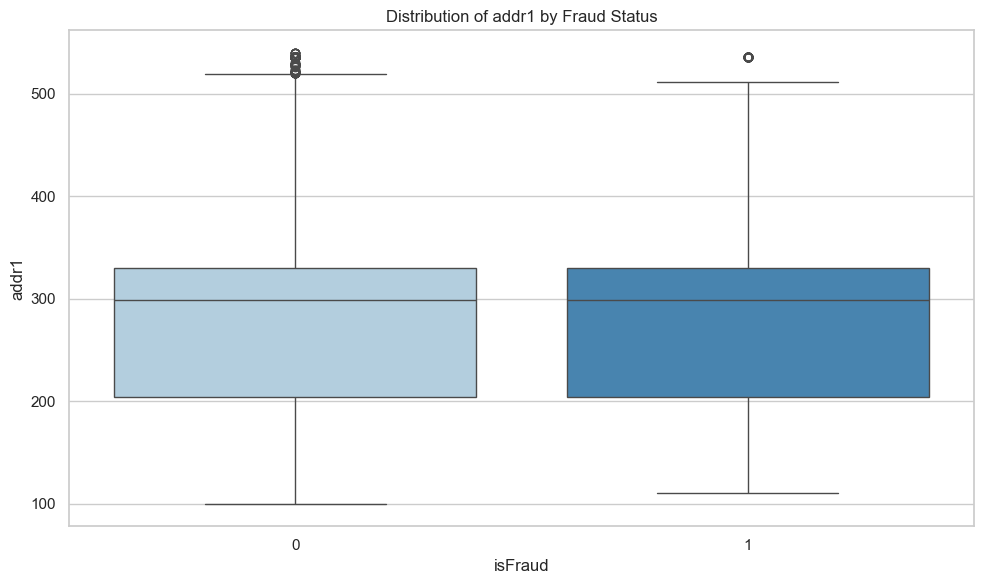

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


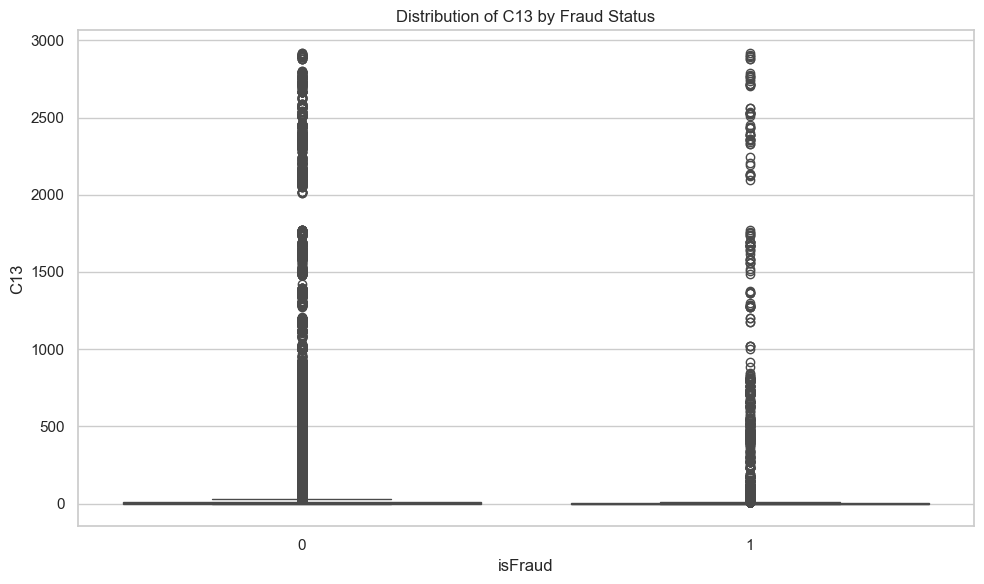

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


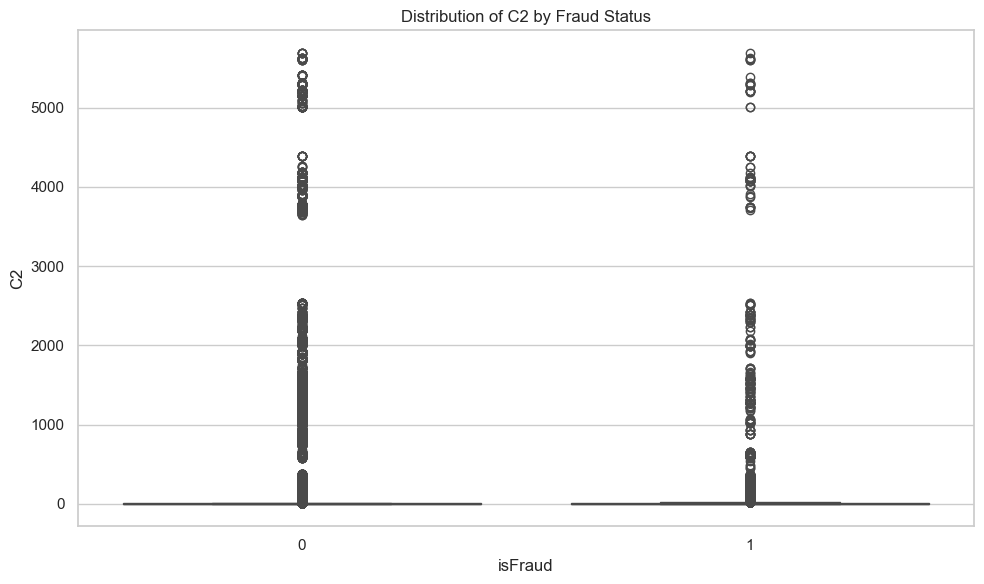

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


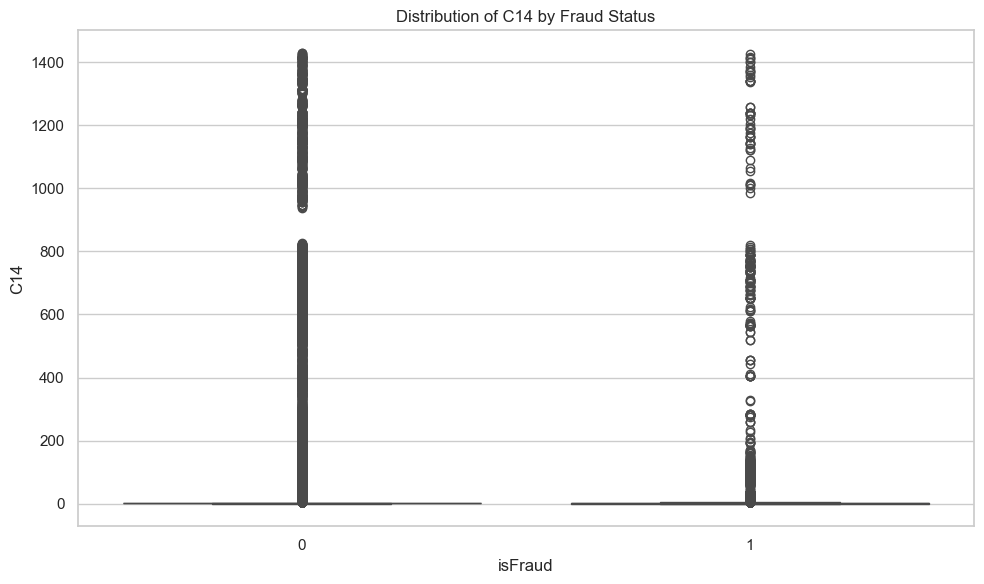

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


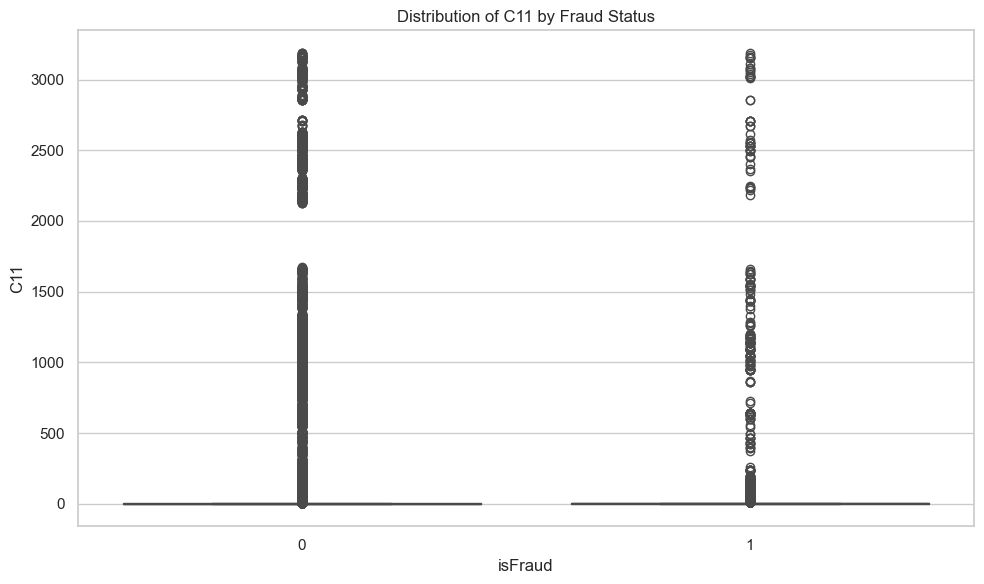

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


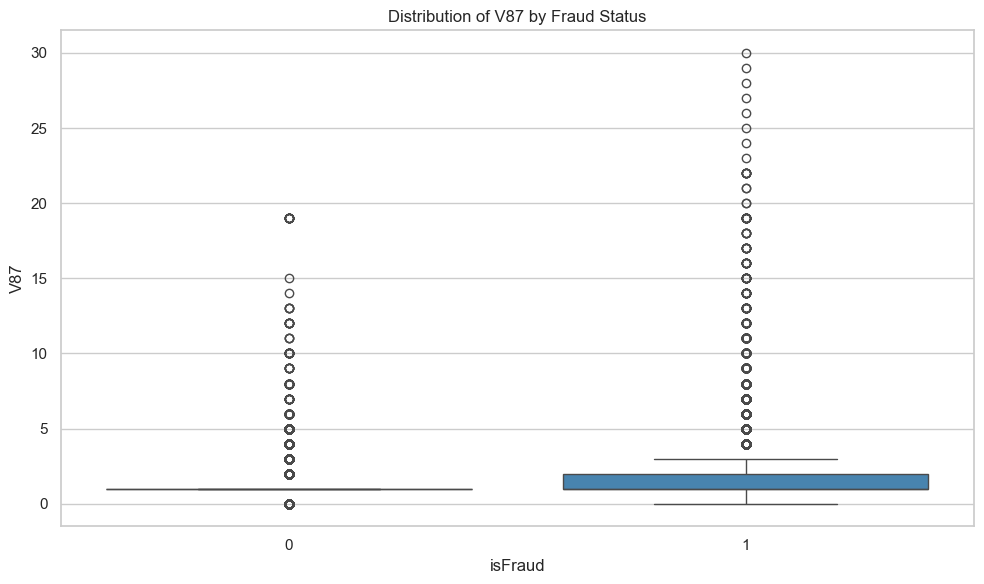

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


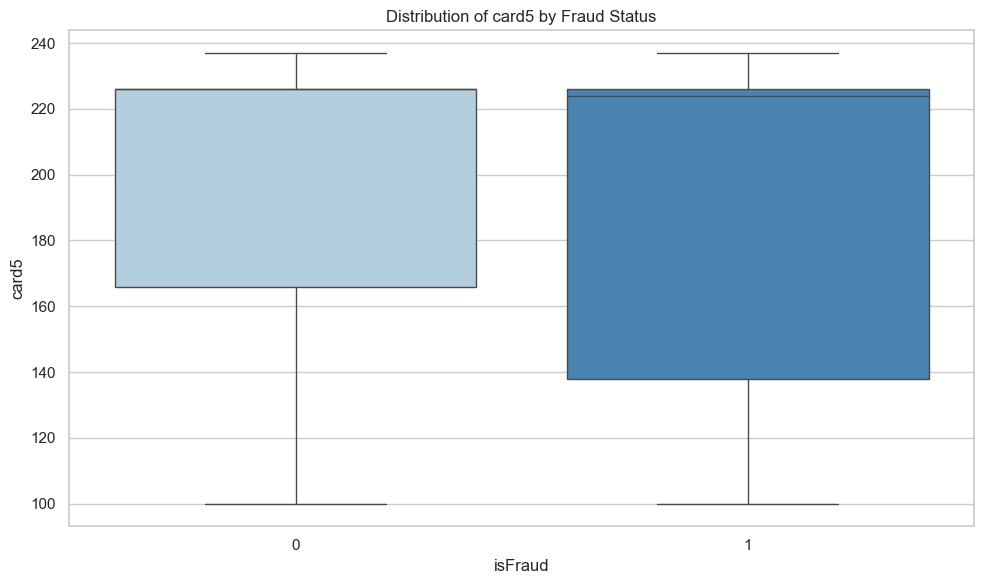

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


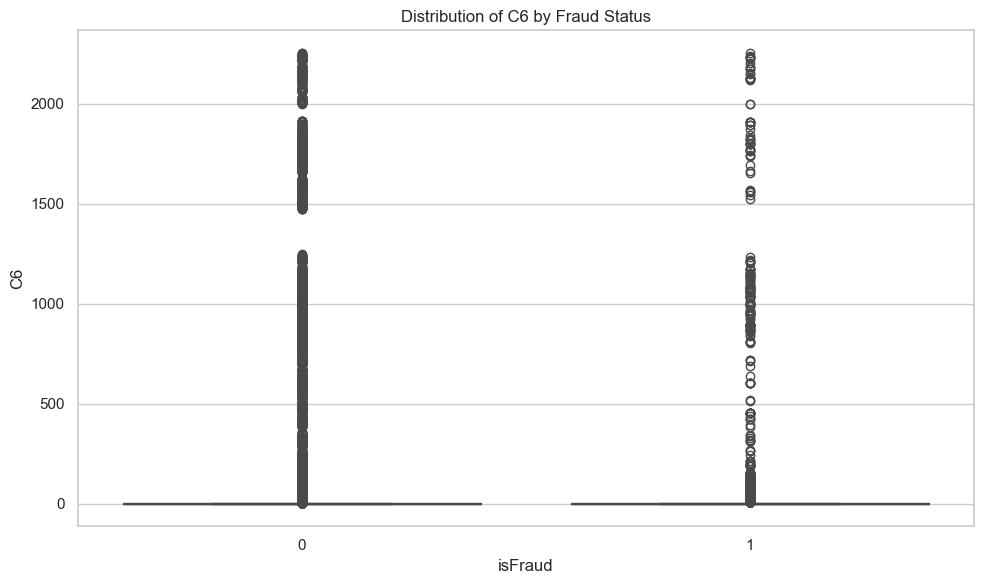

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


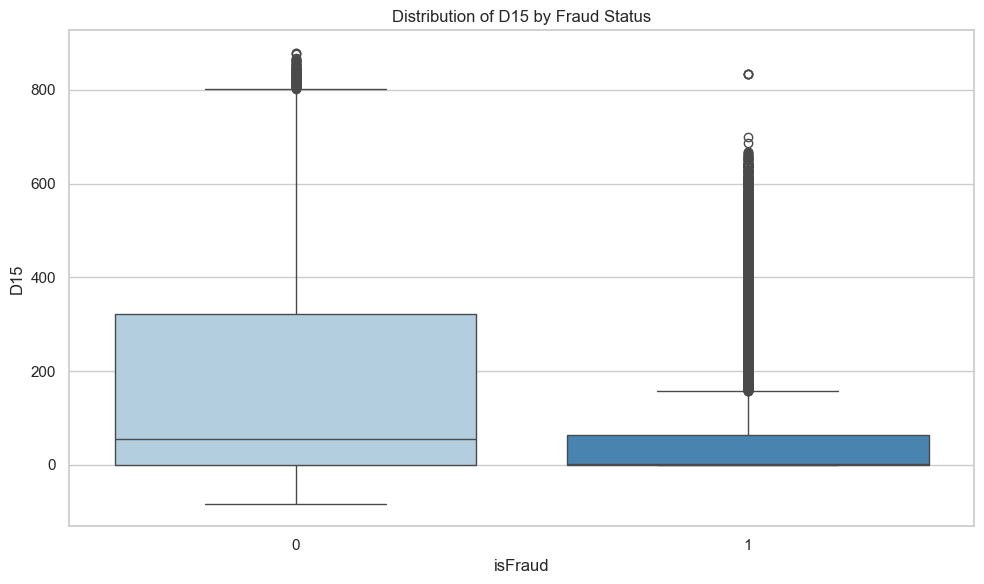

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


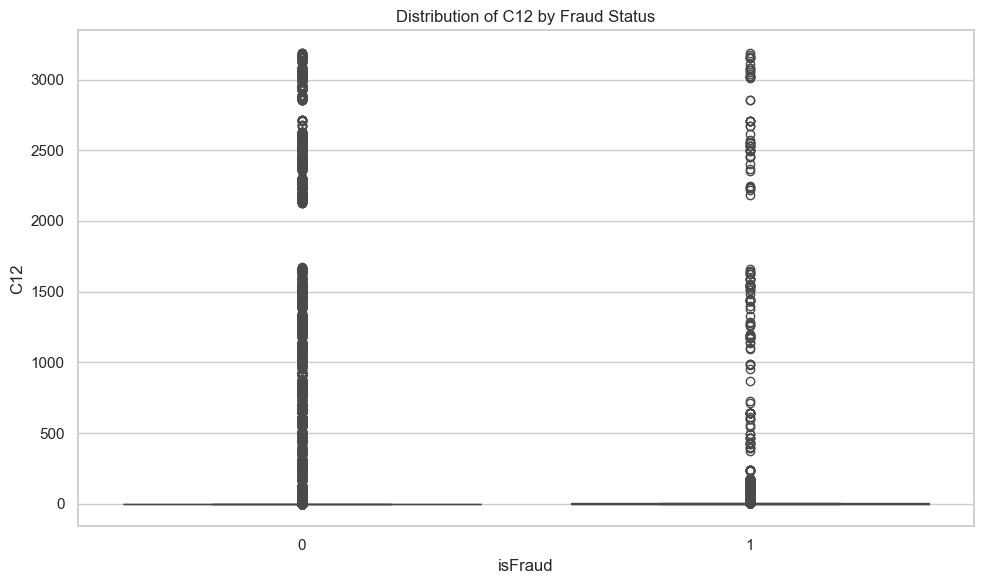

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


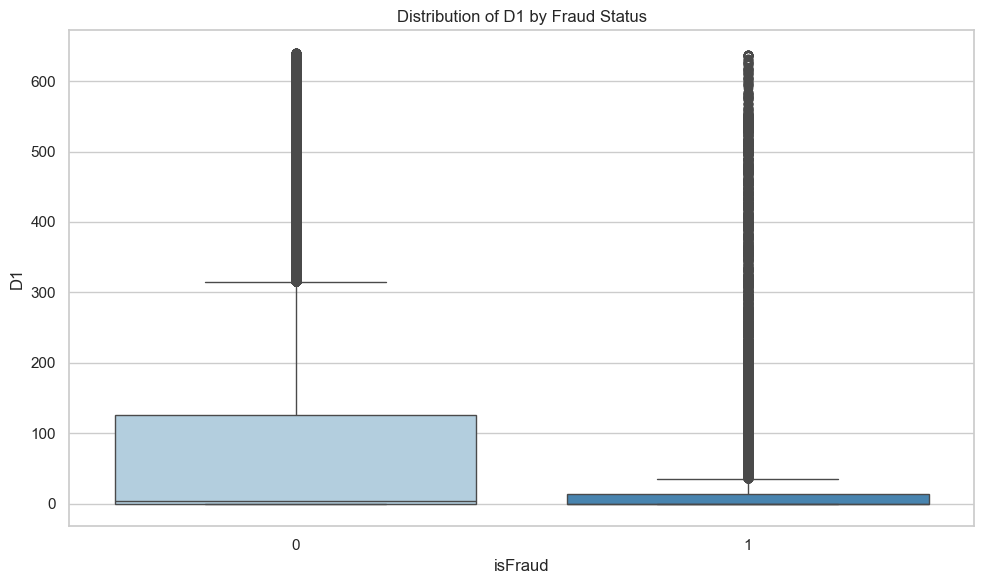

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


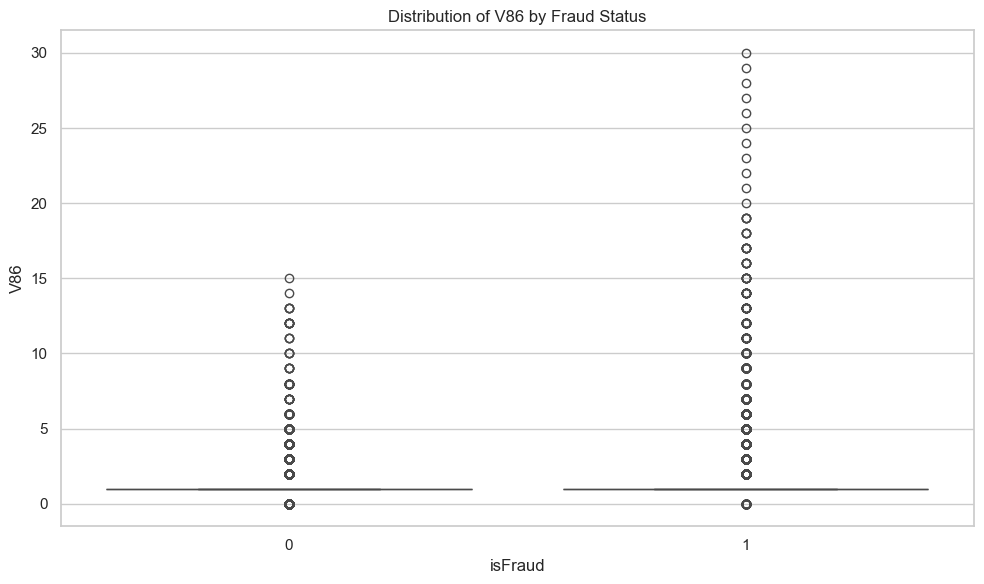

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


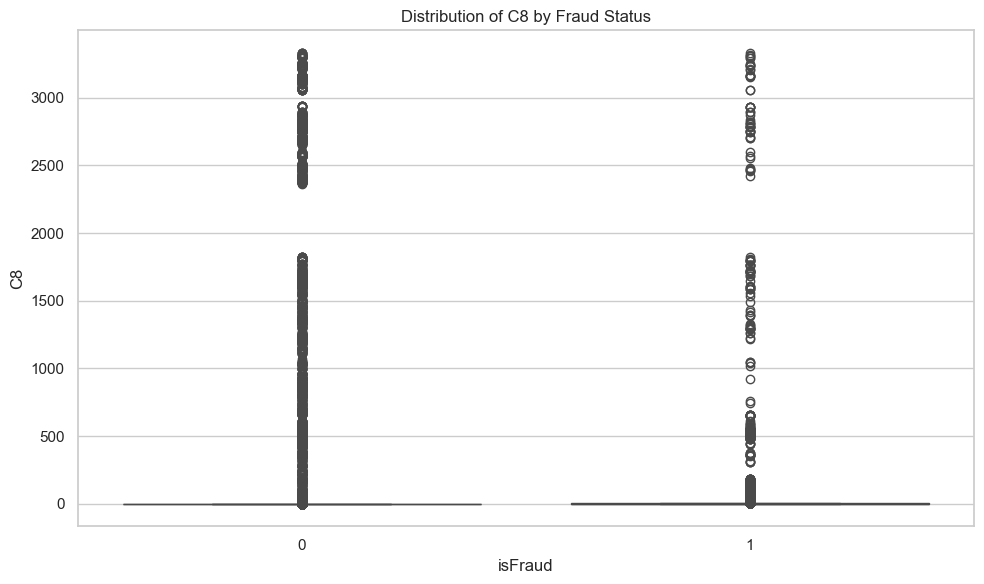

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


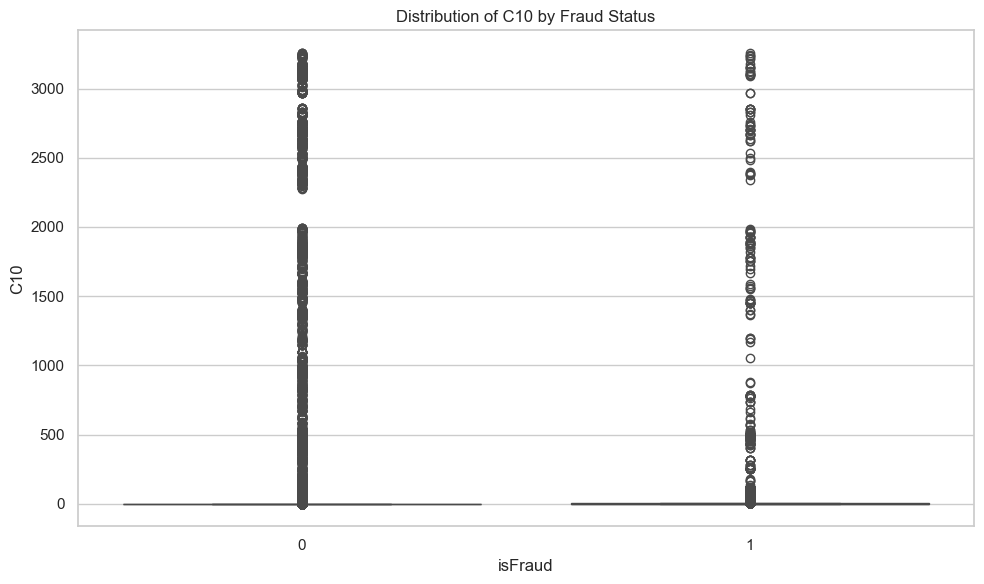

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


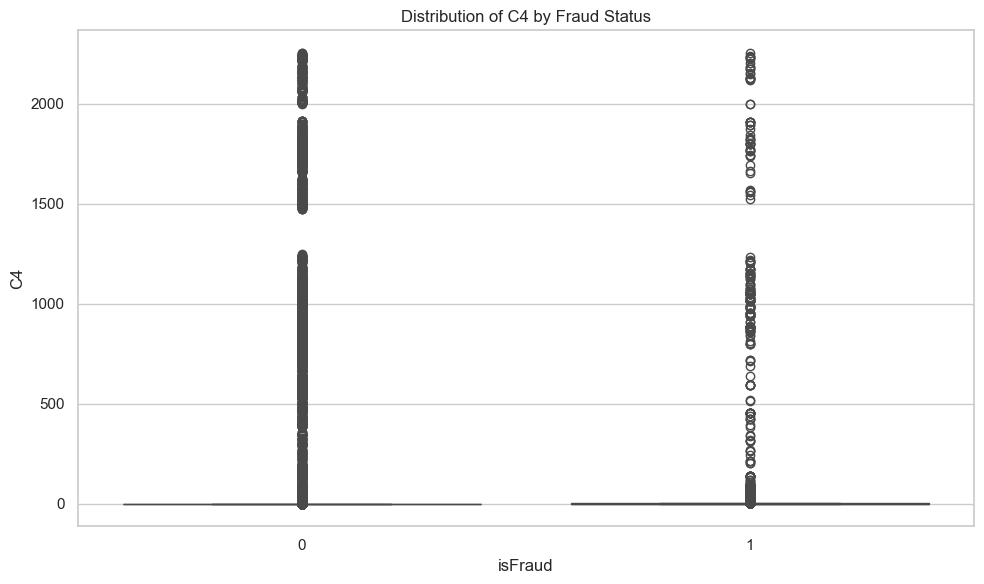

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


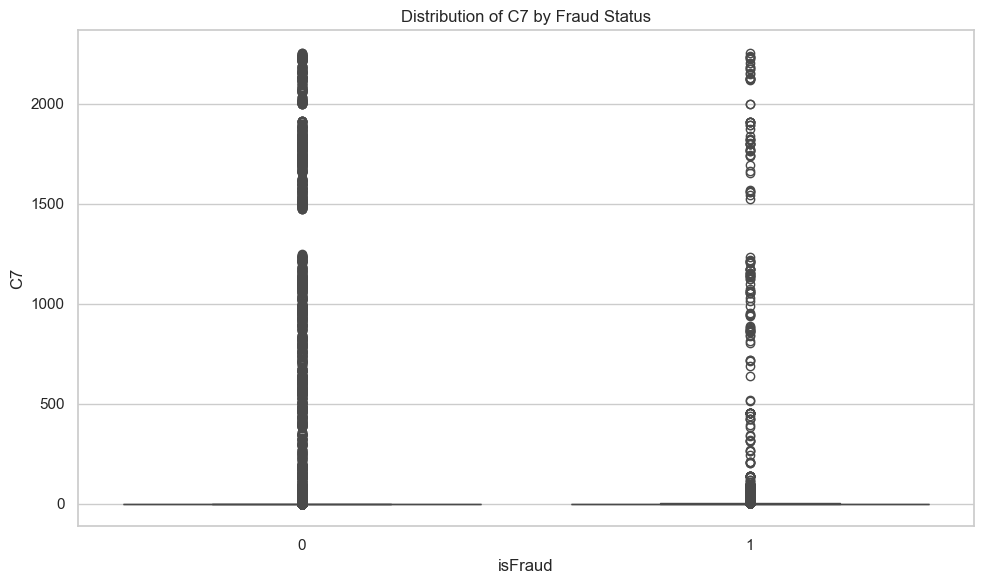

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


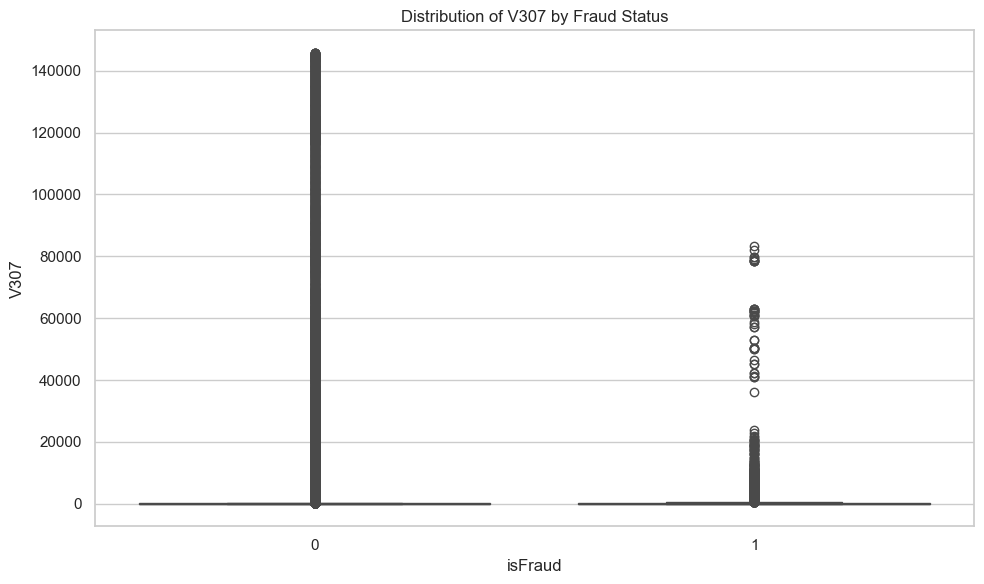

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


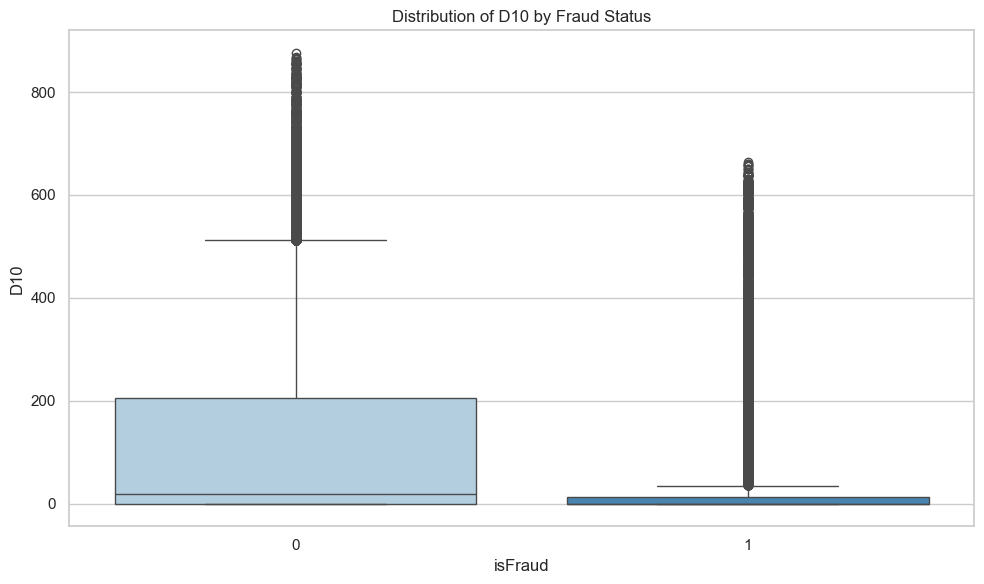

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_4632\279021027.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')


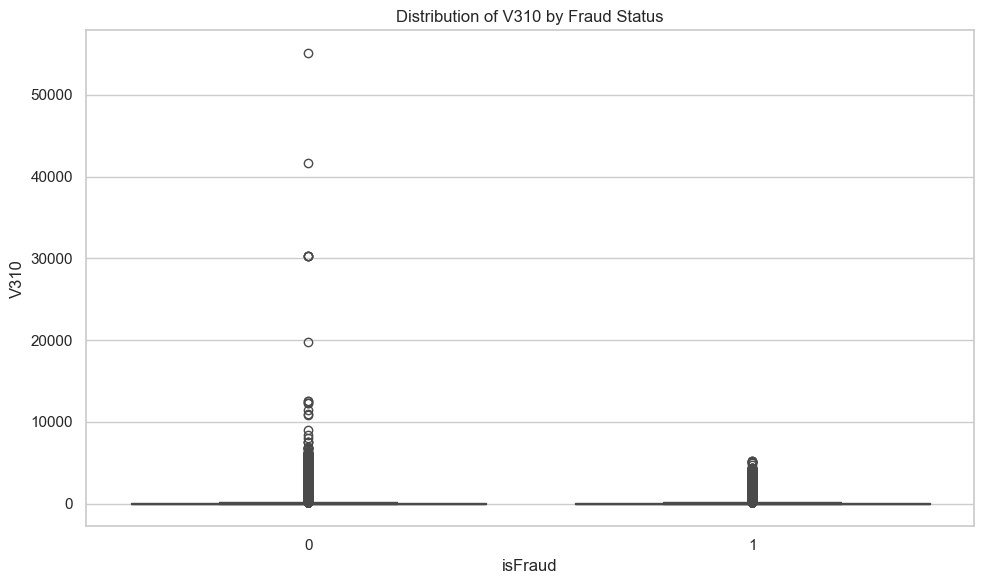

In [25]:
top_feature_names = top_features['feature'].values
top_feature_names = [feature for feature in top_feature_names if feature != 'P_emaildomain_gmail.com']

data = train[top_feature_names+ ['isFraud']]
# Exclude 'P_emaildomain_gmail.com' from top_feature_names if it exists

# Set the plotting style
sns.set(style="whitegrid")
# Proceed with the plotting as before
import matplotlib.pyplot as plt
import seaborn as sns

for feature in top_feature_names:
    plt.figure(figsize=(10, 6))
    
    # Determine the plot type based on the variable type
    if data[feature].dtype == 'float64' or data[feature].dtype == 'int64':
        # Continuous Variable: Boxplot
        sns.boxplot(data=data, x='isFraud', y=feature, palette='Blues')
        plt.title(f'Distribution of {feature} by Fraud Status')
    else:
        # Categorical or dummy Variable: Countplot
        sns.countplot(data=data, x=feature, hue='isFraud', palette='Blues')
        plt.title(f'{feature} vs Fraud Count')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


Split data and scale. 

In [ ]:
# Separate features and target
X = credit_card_data.drop("Class", axis=1)
y = credit_card_data["Class"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The block below can take longer than 5 mins to run depending on you computer specs.

In [ ]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        f"{model.__class__.__name__} Classification Report:\n",
        classification_report(y_test, y_pred),
    )
    print(
        f"{model.__class__.__name__} ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}\n"
    )


# Logistic Regression
logistic_model = LogisticRegression()
evaluate_model(logistic_model, X_train_scaled, y_train, X_test_scaled, y_test)

# Decision Tree
dtree_model = DecisionTreeClassifier()
evaluate_model(dtree_model, X_train, y_train, X_test, y_test)

# Random Forest with parallel processing and fewer estimators
rforest_model = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
evaluate_model(rforest_model, X_train, y_train, X_test, y_test)

# # Gradient Boosting with fewer estimators
gboost_model = GradientBoostingClassifier(n_estimators=50)
evaluate_model(gboost_model, X_train, y_train, X_test, y_test)

# XGBoost with fewer estimators and parallel processing
xgb_model = XGBClassifier(
    n_estimators=50, eval_metric="logloss", n_jobs=-1, random_state=42
)
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

In [ ]:
# Define a function to store performance metrics for each model
def evaluate_model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Check if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        auc_score = (
            None  # Or use a default score like 0.5 if predict_proba is not available
        )

    f1_score = report["weighted avg"]["f1-score"]
    return auc_score, f1_score


# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
}

# Initialize lists to store results
auc_scores = []
f1_scores = []
model_names = []

# Evaluate each model
for name, model in models.items():
    auc, f1 = evaluate_model_performance(
        model, X_train_scaled, y_train, X_test_scaled, y_test
    )
    auc_scores.append(auc)
    f1_scores.append(f1)
    model_names.append(name)

# Store results in a DataFrame
results = pd.DataFrame(
    {"Model": model_names, "ROC AUC Score": auc_scores, "F1 Score": f1_scores}
)

# Plotting metrics
metrics = {"ROC AUC Score": auc_scores, "F1 Score": f1_scores}
for metric_name, scores in metrics.items():
    plt.figure(figsize=(10, 5))
    plt.plot(model_names, scores, marker="o", label=metric_name)
    plt.xlabel("Model")
    plt.ylabel(metric_name)
    plt.title(f"Model {metric_name}")
    plt.legend()
    plt.grid(True)
    plt.show()